# Sentinel 2 NDVI Demo

The following notebook is intended as a proof of concept that demonstrates how the Planet OS API can be used to query a custom Sentinel 2 NDVI product using a polygon sourced from a geojson file.

A cloud mask has been applied to the Sentinel 2 NDVI data to replace cloudy values with `NaNs`. If you'd prefer to work with the original, non-masked product, you can replace the dataset ID accordingly:

* sentinel2_kenya_clouds_ndvi => [sentinel2_kenya_ndvi](http://data.planetos.com/datasets/sentinel2_kenya_ndvi)

Note that the data and API endpoints used in this notebook are not actively supported by Planet OS and may be updated or removed without notice.

In [1]:
%matplotlib inline

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import dateutil.parser
from shapely.geometry import Point
import simplejson as json
from urllib.parse import urlencode
from urllib.request import urlopen, Request

A Planet OS API key is required to run this notebook. Keys are displayed in the [account settings](http://data.planetos.com/account/settings/) page on the Planet OS Datahub. If you do not have a Planet OS account, you can [sign up for free](http://data.planetos.com/plans).

In [2]:
apikey = '535871ea3d554497843ab250a497e626'

Let's begin by loading a sample farm polygon in GeoJSON format. We'll use `geopandas` to read the raw .json file and create a GeoDataFrame with the geometry, centroid and area of the farm.

In [3]:
farm_geo = r'../geojson/sample-farm.json'
gp_farm = gpd.read_file(farm_geo)
gp_farm['centroid'] = gp_farm.centroid
gp_farm['area'] = gp_farm.area
gp_farm

,geometry,centroid,area
0,"POLYGON Z ((36.621035 -0.957993333333333 0, 36...",POINT (36.62117917585404 -0.9584909201199898),1.531889e-07


We'll need some details about the geometry in order to query the API and create some plots. Let's extract the centroid latitude and longitude, and also build a url-friendly polygon that we'll use to query the NDVI data.

centroid          : 36.62117917585404, -0.9584909201199898
original points   : 213
simplified points : 35


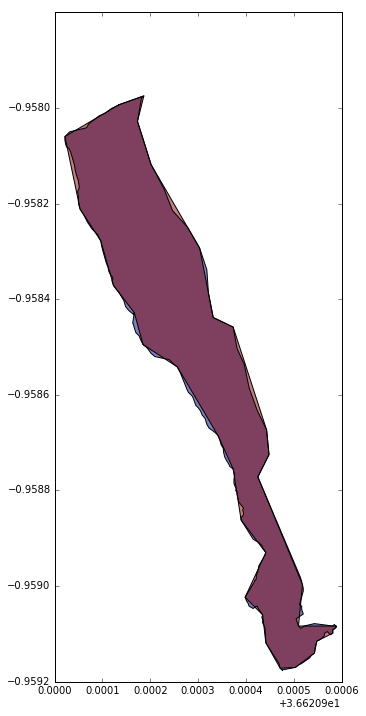

In [4]:
# Set the latitude and longitude using the centroid values
gp_farm_0 = gp_farm.iloc[0]
longitude = gp_farm_0.centroid.x
latitude = gp_farm_0.centroid.y

# The original polygon is complex and unfortunately the polygon must
# currently be passed as a url query parameter. In order to ensure
# our url length is acceptable, let's simplify the polygon.
gp_farm_simple = gp_farm_0.geometry.simplify(0.00001)

# Create the polygon query parameter string for our API query
x,y = gp_farm_simple.exterior.coords.xy
pcoords = []
for i, v in enumerate(x):
    pcoords.append("[%s,%s]" % (v, y[i]))
polygon_str = "[" + ','.join(pcoords) + "]"

# Some stats and a plot to show the original vs. simplified polygon
print("centroid          : %s, %s" % (longitude, latitude))
print("original points   : %s" % len(gp_farm_0.geometry.exterior.coords))
print("simplified points : %s" % len(gp_farm_simple.exterior.coords))

gp_farm.loc[1]=[gp_farm_simple, gp_farm_simple.centroid, gp_farm_simple.area]
gp_farm.plot(figsize=(12,12))

We'll build the rest of our API query below, then request a single value via `count=1` so we can then extract the maximum number of available values from the `stats` section of the response.

In [ ]:
# Set the Planet OS dataset ID and variable of interest
id = 'sentinel2_kenya_clouds_ndvi'
var = 'ndvi'

query_dict = {'polygon':polygon_str,
              'apikey': apikey,
              'var': var,
              'count': 1,
              'max_count': 'true',
              }
query = urlencode(query_dict)

api_url = "http://api.planetos.com/v1/datasets/%s/point?%s" % (id, query)
request = Request(api_url)
response = urlopen(request)
response_json = json.loads(response.read())

stats = response_json['stats']
max_count = stats['maxCount']
print('Stats: ', stats)

Stats:  {'count': 1, 'timeMax': '2016-08-16T07:39:39', 'timeMin': '2016-07-16T08:08:01', 'maxCount': 66, 'offset': 0, 'nextOffset': 1}


Now that we have a `max_count` value, we'll query the API for all available data within the polygon.

In [ ]:
query_dict.update({'count': max_count})
query = urlencode(query_dict)

api_url = "http://api.planetos.com/v1/datasets/%s/point?%s" % (id, query)
request = Request(api_url)
response = urlopen(request)
response_json = json.loads(response.read())
data = response_json['entries']

# let's flatten the response and create a Pandas dataframe
df = pd.io.json.json_normalize(data)

# then index by time using the axes.time column
pd.to_datetime(df["axes.time"])
df.set_index('axes.time', inplace=True)

print(df.count())
df.head()

Note that due to cloud coverage, some timestamps have NaN values for NDVI. Let's remove those items from the dataframe and save it as a new one sorted by time descending.

In [ ]:
df_ndvi = df.dropna().sort_index(ascending=False)
# get unique time stamps
times = pd.Series(df_ndvi.axes[0]).unique()
print(df_ndvi.describe())
print("\n%s Timestamps: %s\n" % (len(times),times))
df_ndvi.head()

Let's create a boxplot of NDVI values by unique coordinate to highlight variance over the provided timestamps.

In [ ]:
df_ndvi.boxplot(column='data.ndvi', by=['axes.latitude', 'axes.longitude'], figsize=(16,8))
plt.xticks(rotation=90)
plt.show()

## Plotting With Folium

We'll use `folium` and Mapbox basemaps to plot the data on a map. This requires a Mapbox account and access token.

Any Mapbox classic map ID can be used (see https://www.mapbox.com/api-documentation/#maps). As an alternative, Folium can plot using open streetmaps, which does not require an account.

In [ ]:
# Insert your own Mapbox token below. This one below may disappear
# without warning and is not intended for use outside of this notebook.
mapbox_token = 'pk.eyJ1IjoiY2thbGltYSIsImEiOiJjaXM2bGpiOXcwMDBiMnNucHo5M2VtNjJ5In0.-_VJKoioKQVzGUmgaf-3iA'
mapbox_map_id = 'outdoors-v9' #satellite-streets-v9
mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/%s/tiles/256/{z}/{x}/{y}?access_token=%s' % (mapbox_map_id, mapbox_token)

# initialize the folium map
kenya_map = folium.Map(location=[latitude, longitude], tiles=mapbox_tileset, attr="Mapbox", zoom_start=19, max_zoom=20)

# add a marker of our point of interest
popup = "Farm: %s, %s" % (latitude, longitude)
folium.Marker([latitude, longitude], popup=popup, icon=folium.Icon(color='green', icon='leaf')).add_to(kenya_map)

# original farm outline
kenya_map.choropleth(geo_path=farm_geo, fill_opacity=0.1)

# custom color map
cm = folium.colormap.LinearColormap(['#000000','#ffffff', '#fcfc8e', '#007e66'],
                                    [-1.0,0,0,1.0],
                                    vmin=-1.0,
                                    vmax=1.0,
                                    caption='NDVI')

# Group the dataframe by latitude and longitude axes to isolate unique points.
df_ndvi_by_point = df_ndvi.reset_index().drop(['context',], axis=1).groupby(['axes.latitude','axes.longitude'])

# Create markers for each point using the most recent data (e.g. iloc[0] based on sort order)
for (lat, lon), group in df_ndvi_by_point:
    ndvi = group['data.ndvi'].iloc[0]
    time = group['axes.time'].iloc[0]
    fill = cm(ndvi)
    date = dateutil.parser.parse(time).strftime("%b %d %Y %H:%M UTC")
    popup = "%s: %s" % (date, round(ndvi,2))
    folium.CircleMarker(location=[lat, lon],
                        radius=1,
                        popup=popup,
                        color=fill,
                        fill_color=fill,
                        fill_opacity=0.9,
                       ).add_to(kenya_map)

    # add color map legend and plot
kenya_map.add_children(cm)
kenya_map

## Plotting with GeoPandas and Matplotlib

An additional example using a geopandas GeoDataFrame and matplotlib is provided below. Note that the colormap is not equivalent between the two plots.

In [ ]:
# create a GeoDataFrame
df_ndvi['geometry'] = df_ndvi.apply(lambda x: Point(float(x['axes.longitude']), float(x['axes.latitude'])), axis=1)
df_ndvi_geo = gpd.GeoDataFrame(df_ndvi, geometry='geometry')
df_ndvi_geo.head()

In [ ]:
ax = df_ndvi_geo.plot(column='data.ndvi', cmap='YlGn', markersize=20, figsize=(12,12))
gp_farm.plot(ax=ax, color='w', ls='--')